In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
import random

%matplotlib inline

In [196]:
movie_df = pd.read_csv('movie_df.csv', index_col=0)
crew_df = pd.read_csv('crew_df.csv', index_col=0)
cast_df = pd.read_csv('cast_df.csv', index_col=0)

movie_df = movie_df[movie_df.id > 0]
movie_df = movie_df[movie_df.original_title.str.len() > 0]

crew_df = crew_df[crew_df.id > 0]
cast_df = cast_df[cast_df.id > 0]

# Remove movies which we don't have nodes for cause adding edges between nonexisting nodes
# creates new nodes with those new ids, it's annoying
cast_df = cast_df[cast_df.m_id.isin(list(movie_df[movie_df.id >= 0].id.astype(int)))]
crew_df = crew_df[crew_df.m_id.isin(list(movie_df[movie_df.id >= 0].id.astype(int)))]

In [465]:
# So create links of cast and crew linkage, these will need to be labeled in the future, 
# but just start with basic links right now 

# In order to do that we'll have to make length 2 combinations from the different movies each cast member (to start with)
# is in 

from itertools import combinations 

cast_lim = cast_df[cast_df.order <= 20]


# So there's some extra ids in here I want to REMOVE cause they're not in the node_list
# list(combinations(list(cast_lim[cast_lim.id == 2].m_id), 2))
cast_edges = []
cast_property = []

for cast_member in tqdm.tqdm(cast_lim.id.unique()):
    tmp_edg_list = list(combinations(list(cast_lim[cast_lim.id == cast_member].m_id), 2))
    cast_edges.extend(tmp_edg_list)
    cast_property.extend([cast_member] * len(tmp_edg_list))

100%|██████████████████████████████████████████████████████████████████████████| 71139/71139 [00:39<00:00, 1800.67it/s]


In [466]:
%%time
G = nx.Graph()

node_list = list(set(movie_df[movie_df.id >= 0].id.astype(int)))
G.add_nodes_from(node_list)
#G.add_edges_from(cast_edges)

# Add property
for x in list(zip(cast_edges, cast_property)):
    G.add_edges_from([x[0]], label=x[1])

Wall time: 4.53 s


In [467]:
from itertools import islice
def k_shortest_paths(G, source, target, k, weight=None):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )
for path in k_shortest_paths(G, 11, 188927, 1):
    print(path)    

[11, 140607, 188927]


In [468]:
# Movie and actor name dictionaries for displaying better here
movie_dict = movie_df[['id','original_title']].set_index('id').to_dict()['original_title']
cast_dict = cast_df[['id','name']].set_index('id').to_dict()['name']

In [469]:
m1 = 54138
m2 = 188927


def find_linkage(G,m1,m2):
    # There for sure is a nicer way than using this function with a length of 1 then upacking it, 
    # but functional is better than correct
    
    m1_name = movie_dict[m1]
    m2_name = movie_dict[m2]
    
    print("Finding link from {} to {}".format(m1_name, m2_name))
    print("")
    
    try:
        shortest_path = k_shortest_paths(G, m1, m2, 1)[0]
        sub = G.subgraph(shortest_path)
    except:
        print("No known link")
        return None

    for edge in sub.edges():
        m1_name = movie_dict[edge[0]]
        m2_name = movie_dict[edge[1]]

        c_name = cast_dict[sub.get_edge_data(edge[0], edge[1])['label']]
        print('Link from {} to {} is {}'.format(m1_name, m2_name, c_name))
    
    return sub

In [470]:
m1, m2 = random.sample(list(movie_dict.keys()), 2)

m1, m2 = 15, 2039

find_linkage(G,m1,m2)

Finding link from Citizen Kane to Moonstruck

Link from Citizen Kane to The Transformers: The Movie is Orson Welles
Link from The Transformers: The Movie to The Little Mermaid is Frank Welker
Link from The Little Mermaid to Moonstruck is Robert Weil


In [471]:
movie_df[movie_df.original_title.str.contains('Kane')]

,adult,id,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
2259,False,32985.0,25.757,Solomon Kane,NaN,2009-09-16,19652185.0,5.9,894.0,45000000.0
3713,False,15.0,17.642,Citizen Kane,NaN,1941-04-17,23217674.0,8.1,3334.0,839727.0


In [472]:
movie_df[movie_df.original_title.str.contains('Moonstruck')]

,adult,id,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
9291,False,2039.0,10.451,Moonstruck,NaN,1987-12-16,80640528.0,6.8,498.0,0.0


# Example Visualization, Will need to be improved for path analysis

In [473]:
movie_subset = movie_df[movie_df.original_title.str.contains('Star Wars')]

movie_nodes = list(movie_subset.id)
label_dict = pd.Series(movie_subset.original_title.values,index=movie_nodes).to_dict()
mG = G.subgraph(movie_nodes)

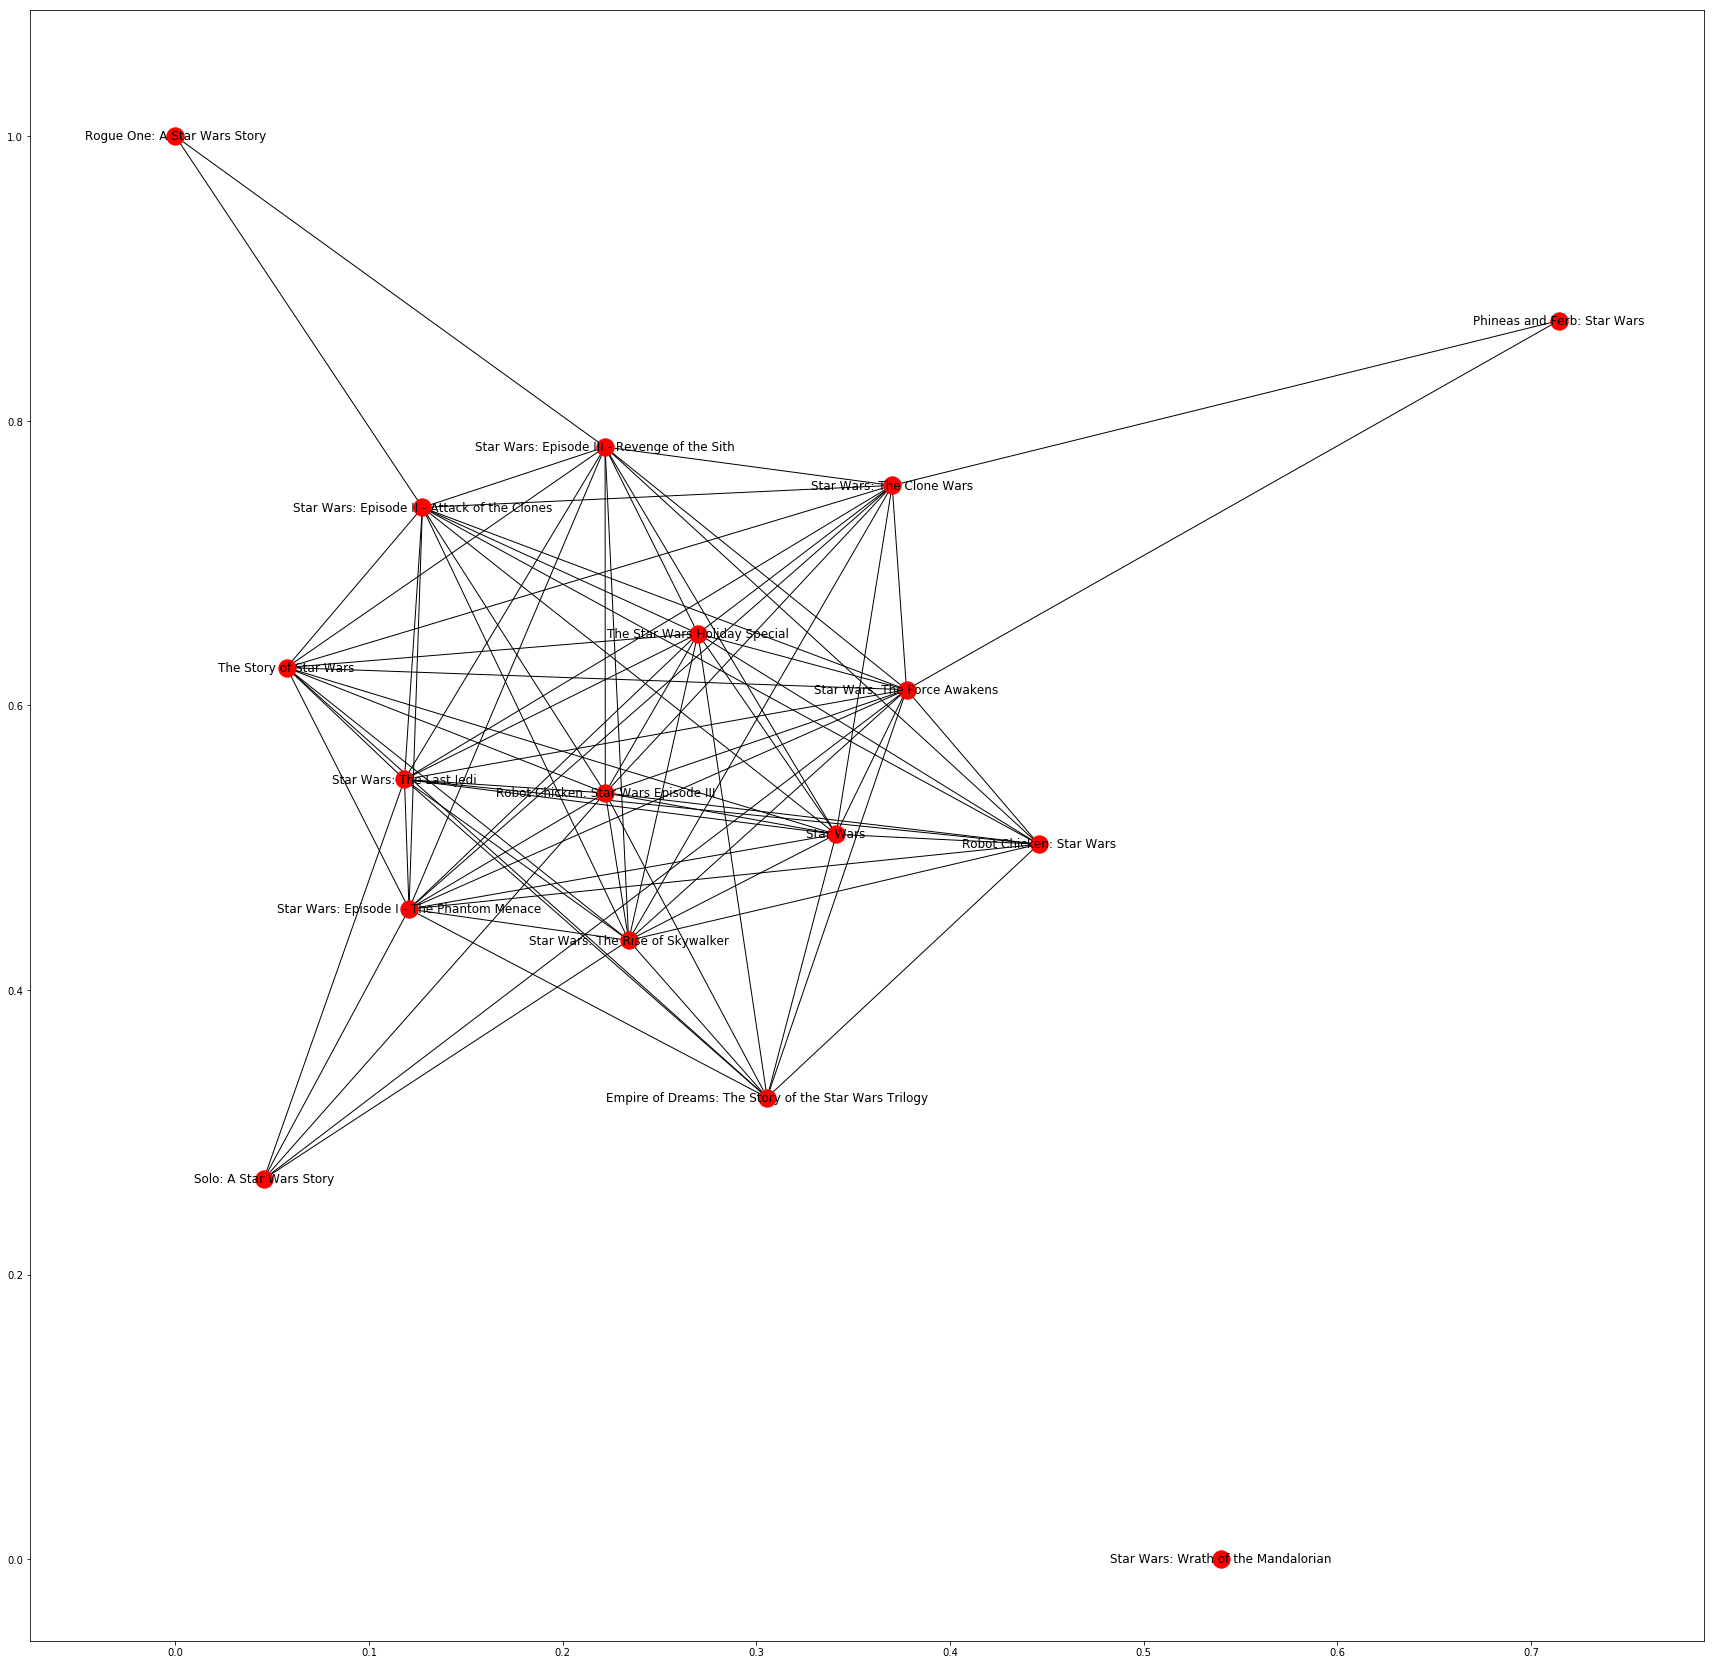

In [474]:
fig, ax = plt.subplots(figsize=(30, 30))

nx.draw_networkx(mG, ax=ax, labels=label_dict)
#nx.draw_circular(mG, ax=ax, labels=label_dict)

In [475]:
# Graph at distance 2 from some John Wick let's say
#movie_df[movie_df.original_title.str.contains('John Wick')]
path = nx.single_source_shortest_path_length(G ,source=2039,cutoff=1)
path[2039] = 0

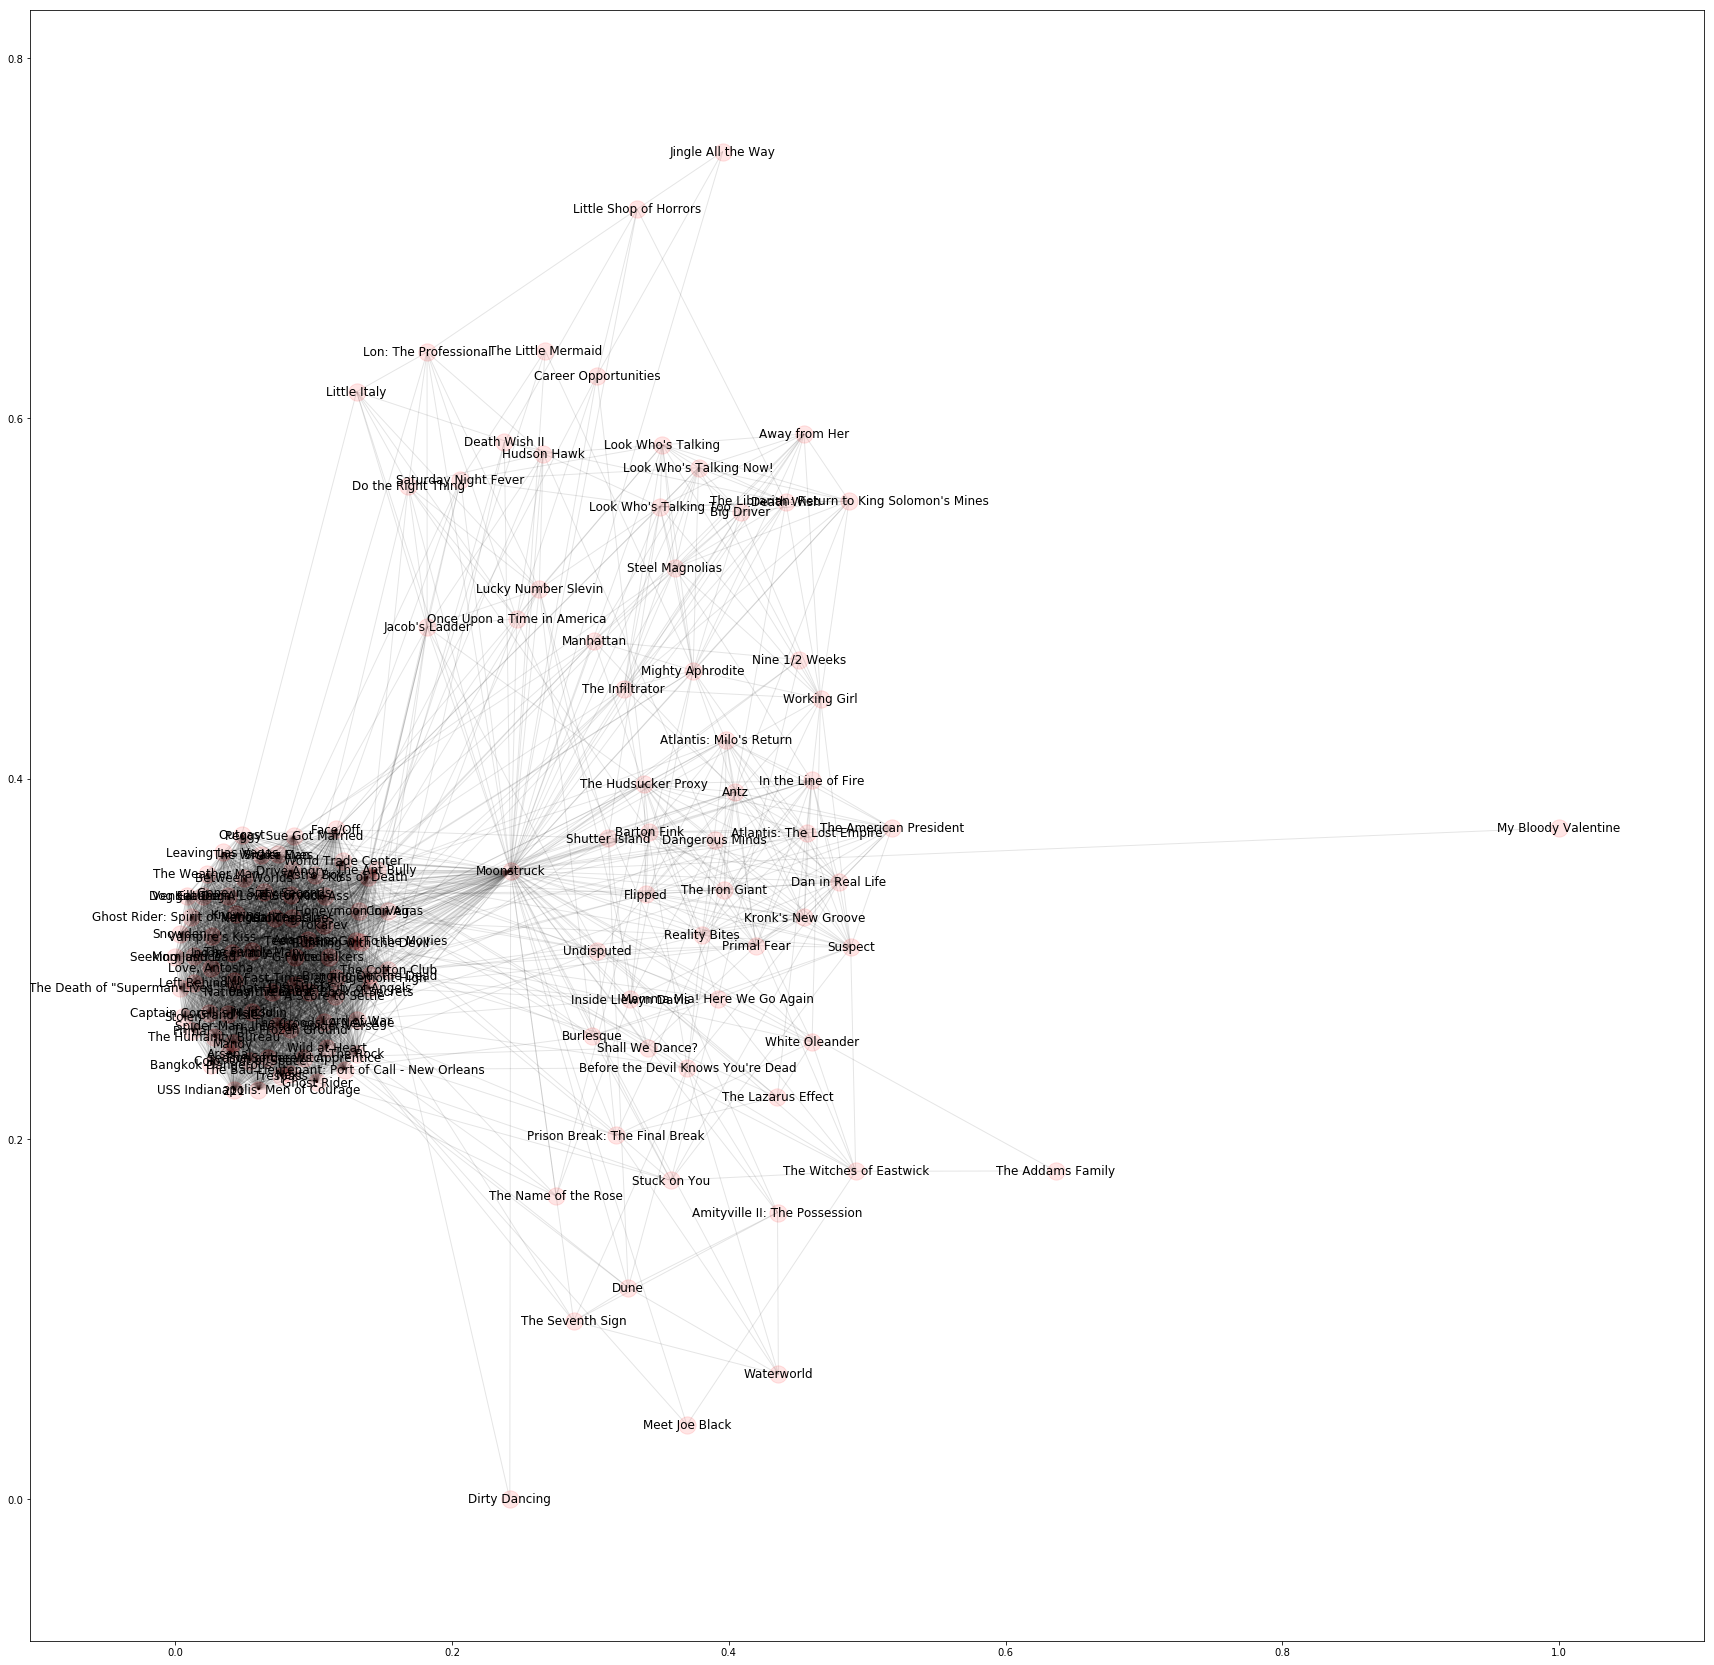

In [476]:
fig, ax = plt.subplots(figsize=(30, 30))

# I don't think this label dict is in correct order is tyhe problem

id_list = list(path.keys())

label_dict = pd.Series(movie_df.set_index('id').loc[id_list].original_title.values,index=id_list).to_dict()

len_G = G.subgraph(list(path.keys()))

pos=nx.spring_layout(len_G)

nx.draw_networkx(len_G, pos=pos, ax=ax, labels=label_dict, alpha=0.10)

# Visualizing Nick Cage Movies

100%|██████████████████████████████████████████████████████████████████████████████| 597/597 [00:00<00:00, 2219.33it/s]


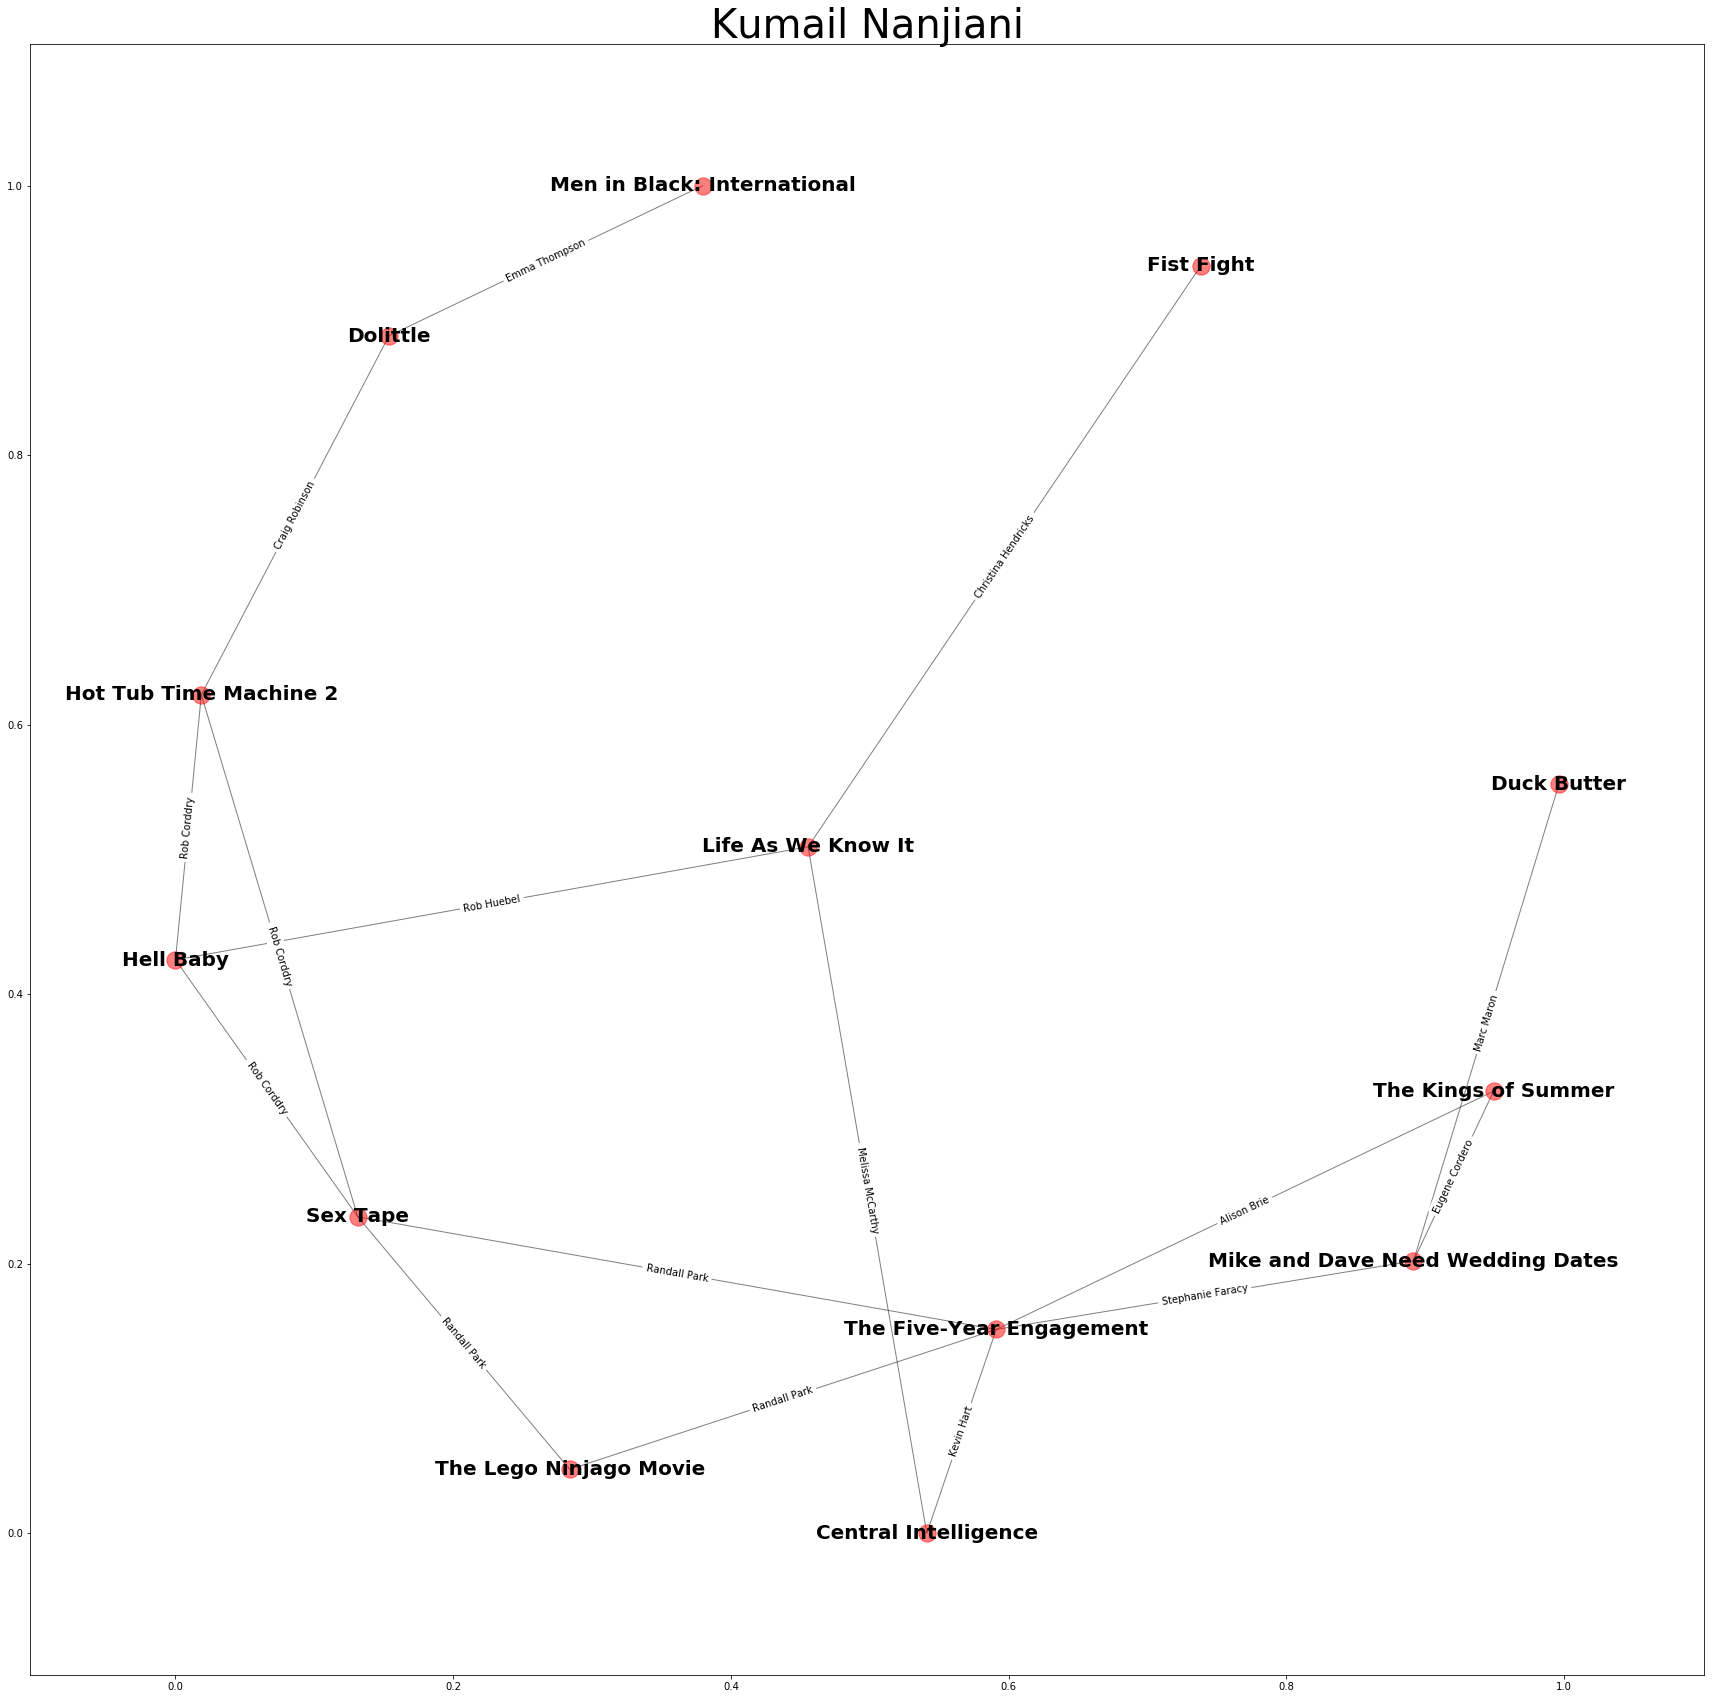

In [551]:
# Oh so I'll need a thing which generates the entire graph but skips records with cast id = whatever

actor = "Kumail Nanjiani"

t = cast_df[~cast_df.name.isnull()]
cage_ids = list(t[t.name.str.contains(actor)].m_id.unique())
cage_actor_id = list(t[t.name.str.contains(actor)].id.unique())[0]



###
##Next Section
###

# Only get cast members who were in a nicholas cage movie
cast_lim = cast_df[cast_df.order <= 50]
cast_lim = cast_lim[cast_lim.m_id.isin(cage_ids)]

# So there's some extra ids in here I want to REMOVE cause they're not in the node_list
# list(combinations(list(cast_lim[cast_lim.id == 2].m_id), 2))
cast_edges = []
cast_property = []


for cast_member in tqdm.tqdm(cast_lim.id.unique()):
    if cast_member == cage_actor_id:
        pass
    else:
        tmp_edg_list = list(combinations(list(cast_lim[cast_lim.id == cast_member].m_id), 2))
        cast_edges.extend(tmp_edg_list)
        cast_property.extend([cast_member] * len(tmp_edg_list))

cage_G = nx.Graph()

node_list = cage_ids
cage_G.add_nodes_from(node_list)
#cage_G.add_edges_from(cast_edges)

# Add property
for x in list(zip(cast_edges, cast_property)):
    cage_G.add_edges_from([x[0]], label=x[1])
    
    
###
# Next Section
### 


fig, ax = plt.subplots(figsize=(30, 30))

'''cage_graph = G.subgraph(cage_ids)
cage_G = G.subgraph(cage_ids)'''

# Generate connected components and select the largest:
largest_component = max(nx.connected_components(cage_G), key=len)

# Create a subgraph of G consisting only of this component:
cage_G = cage_G.subgraph(largest_component)

edge_labels = {}
for x in cage_G.edges():
    edge_labels[(x[0], x[1])] = cast_dict[cage_G.get_edge_data(x[0], x[1])['label']]
    edge_labels[(x[1], x[0])] = cast_dict[cage_G.get_edge_data(x[0], x[1])['label']]

label_dict = pd.Series(movie_df.set_index('id').loc[cage_G.nodes()].original_title.values,index=cage_G.nodes()).to_dict()
pos=nx.spring_layout(cage_G, k=1 / np.sqrt(len(cage_G.nodes())))

#pos = nx.spectral_layout(cage_G)
#pos = nx.drawing.circular_layout(cage_G)

nx.draw_networkx(cage_G, pos=pos, ax=ax, labels=label_dict, alpha = 0.5, font_size=20, font_weight='bold')
nx.draw_networkx_edge_labels(cage_G, pos=pos, ax=ax, edge_labels=edge_labels)

plt.title(actor, fontsize=40)
plt.show()

In [545]:
500916 in cage_G.nodes()

False

In [542]:
%debug

> c:\users\nick\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py(837)draw_networkx_edge_labels()
    835     text_items = {}
    836     for (n1, n2), label in labels.items():
--> 837         (x1, y1) = pos[n1]
    838         (x2, y2) = pos[n2]
    839         (x, y) = (x1 * label_pos + x2 * (1.0 - label_pos),

ipdb> x1
0.023162167859530142
ipdb> y1
0.6354767798473171
ipdb> n1
500916
ipdb> pos[500916]
*** KeyError: 500916
ipdb> exit()


In [552]:
movie_df[movie_df.original_title.str.contains('Love Guru')]

,adult,id,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget


In [ ]:
1 / np.sqrt(len(cage_G.nodes()))

# Page Rank On Undirected Graph

In [181]:
%%time
pr = nx.pagerank(G)

Wall time: 27.8 s


In [182]:
pr_df = pd.DataFrame.from_dict(pr, orient='index')
pr_df.reset_index(inplace=True)
pr_df.columns = ['id', 'value']

In [183]:
movie_df.set_index('id').loc[list(pr_df.sort_values('value', ascending=False).head(10).id)]

,adult,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
id,,,,,,,,,
76163,False,28.848,The Expendables 2,NaN,2012-08-08,3.149760e+08,6.2,4956.0,100000000.0
77950,False,27.868,Turbo,NaN,2013-07-11,2.825707e+08,6.1,2269.0,135000000.0
16577,False,22.949,Astro Boy,NaN,2009-10-15,1.955107e+07,6.3,1004.0,10000000.0
95,False,30.898,Armageddon,NaN,1998-07-01,5.537996e+08,6.8,5480.0,140000000.0
272,False,41.868,Batman Begins,NaN,2005-06-10,3.742187e+08,7.7,15081.0,150000000.0
39514,False,19.018,RED,NaN,2010-10-13,7.166496e+07,6.7,4929.0,58000000.0
4995,False,16.842,Boogie Nights,NaN,1997-10-07,4.310159e+07,7.6,1964.0,15000000.0
1701,False,20.153,Con Air,NaN,1997-06-05,2.240122e+08,6.7,2664.0,75000000.0
49026,False,47.041,The Dark Knight Rises,NaN,2012-07-16,1.081041e+09,7.7,16790.0,250000000.0


## With Money

In [245]:
#p_dict = pd.Series(np.log10(movie_df.fillna(0).reset_index()['revenue'].values + 1),
#          index=movie_df.fillna(0).reset_index()['id']).to_dict()

p_dict = pd.Series(movie_df.fillna(0).reset_index()['revenue'].values,
          index=movie_df.fillna(0).reset_index()['id']).to_dict()

In [198]:
%%time
pr = nx.pagerank(G, personalization=p_dict)

Wall time: 33.9 s


In [199]:
pr_df = pd.DataFrame.from_dict(pr, orient='index')
pr_df.reset_index(inplace=True)
pr_df.columns = ['id', 'value']

In [210]:
movie_df.set_index('id').loc[list(pr_df.sort_values('value', ascending=False).head(25).id)]

,adult,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
id,,,,,,,,,
77950,False,27.868,Turbo,NaN,2013-07-11,2.825707e+08,6.1,2269.0,135000000.0
16577,False,22.949,Astro Boy,NaN,2009-10-15,1.955107e+07,6.3,1004.0,10000000.0
95,False,30.898,Armageddon,NaN,1998-07-01,5.537996e+08,6.8,5480.0,140000000.0
76163,False,28.848,The Expendables 2,NaN,2012-08-08,3.149760e+08,6.2,4956.0,100000000.0
272,False,41.868,Batman Begins,NaN,2005-06-10,3.742187e+08,7.7,15081.0,150000000.0
39514,False,19.018,RED,NaN,2010-10-13,7.166496e+07,6.7,4929.0,58000000.0
49026,False,47.041,The Dark Knight Rises,NaN,2012-07-16,1.081041e+09,7.7,16790.0,250000000.0
4995,False,16.842,Boogie Nights,NaN,1997-10-07,4.310159e+07,7.6,1964.0,15000000.0
140300,False,65.626,Kung Fu Panda 3,NaN,2016-01-23,5.211708e+08,6.8,3796.0,145000000.0


In [201]:
movie_df.sort_values('revenue', ascending=False).head(10)

,adult,id,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
94,False,299534.0,190.267,Avengers: Endgame,NaN,2019-04-24,2.797801e+09,8.3,15396.0,356000000.0
379,False,19995.0,71.518,Avatar,NaN,2009-12-10,2.787965e+09,7.5,22205.0,237000000.0
438,False,597.0,62.007,Titanic,NaN,1997-11-18,2.187464e+09,7.9,17907.0,200000000.0
803,False,140607.0,51.444,Star Wars: The Force Awakens,NaN,2015-12-15,2.068224e+09,7.4,15037.0,245000000.0
83,False,299536.0,215.160,Avengers: Infinity War,NaN,2018-04-25,2.046240e+09,8.3,19964.0,300000000.0
392,False,135397.0,81.906,Jurassic World,NaN,2015-06-06,1.671713e+09,6.6,16115.0,150000000.0
116,False,420818.0,167.410,The Lion King,NaN,2019-07-12,1.656943e+09,7.2,6942.0,260000000.0
320,False,24428.0,86.288,The Avengers,NaN,2012-04-25,1.519558e+09,7.7,23322.0,220000000.0
783,False,168259.0,51.840,Furious 7,NaN,2015-04-01,1.515048e+09,7.3,7853.0,190000000.0
61,False,330457.0,284.335,Frozen II,NaN,2019-11-20,1.450027e+09,7.3,6284.0,150000000.0


# Create Links that only go forward

In [230]:
jobs = list(crew_df.job.value_counts().iloc[0:10].index)
top_df = crew_df[crew_df.job.isin(jobs)]

# Add in movie ids and release dates
cast_dates = pd.merge(top_df, movie_df[['id', 'release_date']], left_on='m_id', right_on='id', suffixes=['','_m'])
cast_dates.sort_values('release_date', ascending=True, inplace=True)
cast_dates = cast_dates[~cast_dates.release_date.isnull()]

# Get the following record
cast_dates['nxt_m'] = cast_dates.groupby(['id'])['m_id'].shift(1)

# Only crew with valid following movies
link_df = cast_dates[~cast_dates.nxt_m.isnull() & (cast_dates.m_id != cast_dates.nxt_m)]

In [236]:
crew_edges = [list(x) for x in link_df[['m_id', 'nxt_m']].values]

In [237]:
%%time
G = nx.Graph()

node_list = list(set(link_df.m_id.astype(int)))
G.add_nodes_from(node_list)
G.add_edges_from(crew_edges)

Wall time: 640 ms


In [238]:
%%time
pr = nx.pagerank(G)

Wall time: 3.53 s


In [239]:
pr_df = pd.DataFrame.from_dict(pr, orient='index')
pr_df.reset_index(inplace=True)
pr_df.columns = ['id', 'value']

In [240]:
movie_df.set_index('id').loc[list(pr_df.sort_values('value', ascending=False).head(10).id)]

,adult,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
id,,,,,,,,,
2266.0,False,10.345,"Paris, je t'aime",NaN,2006-06-21,4.857367e+06,6.8,481.0,13000000.0
180.0,False,23.247,Minority Report,NaN,2002-06-20,3.583729e+08,7.3,5822.0,102000000.0
1635.0,False,27.063,The Island,NaN,2005-07-21,1.629492e+08,6.7,3805.0,126000000.0
141052.0,False,112.380,Justice League,NaN,2017-11-15,6.579243e+08,6.2,9710.0,300000000.0
2024.0,False,20.222,The Patriot,NaN,2000-06-28,2.152943e+08,7.1,2520.0,110000000.0
106646.0,False,59.717,The Wolf of Wall Street,NaN,2013-12-25,3.920007e+08,8.0,16206.0,100000000.0
135397.0,False,81.906,Jurassic World,NaN,2015-06-06,1.671713e+09,6.6,16115.0,150000000.0
76757.0,False,37.479,Jupiter Ascending,NaN,2015-02-04,1.839877e+08,5.4,5211.0,176000003.0
49026.0,False,47.041,The Dark Knight Rises,NaN,2012-07-16,1.081041e+09,7.7,16790.0,250000000.0


# With Money

In [246]:
%%time
pr = nx.pagerank(G, personalization=p_dict)

Wall time: 4.76 s


In [247]:
pr_df = pd.DataFrame.from_dict(pr, orient='index')
pr_df.reset_index(inplace=True)
pr_df.columns = ['id', 'value']

In [248]:
movie_df.set_index('id').loc[list(pr_df.sort_values('value', ascending=False).head(10).id)]

,adult,popularity,original_title,original_langue,release_date,revenue,vote_average,vote_count,budget
id,,,,,,,,,
19995.0,False,71.518,Avatar,NaN,2009-12-10,2.787965e+09,7.5,22205.0,237000000.0
299534.0,False,190.267,Avengers: Endgame,NaN,2019-04-24,2.797801e+09,8.3,15396.0,356000000.0
135397.0,False,81.906,Jurassic World,NaN,2015-06-06,1.671713e+09,6.6,16115.0,150000000.0
141052.0,False,112.380,Justice League,NaN,2017-11-15,6.579243e+08,6.2,9710.0,300000000.0
351286.0,False,116.099,Jurassic World: Fallen Kingdom,NaN,2018-06-06,1.303460e+09,6.6,8216.0,170000000.0
299536.0,False,215.160,Avengers: Infinity War,NaN,2018-04-25,2.046240e+09,8.3,19964.0,300000000.0
140607.0,False,51.444,Star Wars: The Force Awakens,NaN,2015-12-15,2.068224e+09,7.4,15037.0,245000000.0
49026.0,False,47.041,The Dark Knight Rises,NaN,2012-07-16,1.081041e+09,7.7,16790.0,250000000.0
315635.0,False,103.876,Spider-Man: Homecoming,NaN,2017-07-05,8.801669e+08,7.4,15034.0,175000000.0
